## K-prototypes demo

In [ ]:
import sys
!{sys.executable} -m pip install kmodes
!{sys.executable} -m pip install gower

In [3]:
# data source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
# data licence: https://github.com/IBM/telco-customer-churn-on-icp4d

import random
import math

import numpy as np
import pandas as pd

import umap
import umap.plot as uplot

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples

from kneed import KneeLocator

from kmodes.kprototypes import KPrototypes
import gower

from numba import njit

random.seed(42)
sns.set_theme()

## Dataset description

The Telco Churn Dataset is a customer behavior dataset that includes information about a telecommunications company's customers and whether or not they discontinued their services within the last month (churned). The dataset is typically used to create predictive models to identify customers who are likely to churn in the future.

- **customerID**: This is a unique identifier for each customer in the dataset.

- **gender**: This indicates the gender of the customer, typically "Male" or "Female".
- **SeniorCitizen**: This is a binary indicator of whether the customer is a senior citizen or not.
- **Partner**: This is a binary indicator of whether the customer has a partner or not.
- **Dependents**: This is a binary indicator of whether the customer has any dependents or not.
- **tenure**: This represents the number of months the customer has been with the company.
- **PhoneService**: This is a binary indicator of whether the customer has a phone service or not.
- **MultipleLines**: This indicates whether the customer has multiple telephone lines.
- **InternetService**: This describes the type of internet service the customer has, typically DSL, Fiber optic, or None.
- **OnlineSecurity**: This is a binary indicator of whether the customer has online security services or not.
- **OnlineBackup**: This is a binary indicator of whether the customer has online backup services or not.
- **DeviceProtection**: This is a binary indicator of whether the customer has device protection services or not.
- **TechSupport**: This is a binary indicator of whether the customer has technical support services or not.
- **StreamingTV**: This is a binary indicator of whether the customer has streaming TV services or not.
- **StreamingMovies**: This is a binary indicator of whether the customer has streaming movie services or not.
- **Contract**: This describes the type of contract the customer has with the company, typically Month-to-month, One year, or Two year.
- **PaperlessBilling**: This is a binary indicator of whether the customer has opted for paperless billing or not.
- **PaymentMethod**: This describes the payment method that the customer uses, such as Electronic check, Mailed check, Bank transfer (automatic), or Credit card (automatic).
- **MonthlyCharges**: This represents the amount charged to the customer monthly.
- **TotalCharges**: This represents the total amount charged to the customer.
- **Churn**: This is a binary indicator of whether the customer churned (discontinued their services) in the last month or not.

Citation : IBM Sample Data Sets - Telco customer churn

## Data loading and preprocessing

In [4]:
# Load the data
telco_path = 'data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
telco_df = pd.read_csv(telco_path)
telco_df = telco_df.drop_duplicates().reset_index(drop=True)

In [ ]:
# Dataset shape
telco_df.shape

(7043, 21)

In [6]:
# Check for missing values
telco_df.isnull().sum(axis=0)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
telco_df['SeniorCitizen'] = telco_df['SeniorCitizen'].astype(int).astype('object')

In [9]:
# Remove rows with non existing TotalCharges
telco_df = telco_df[telco_df['TotalCharges']!=' ']
telco_df['TotalCharges'] = telco_df['TotalCharges'].astype(float)

In [10]:
telco_df.shape

(7032, 21)

In [11]:
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
# Get copy of dataframe in order to preserve original values for cluster analysis
original_df = telco_df.copy()

In [13]:
# Remove columns that will not be used for clustering
other_cols = ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']
other_df = telco_df.loc[:, other_cols]
telco_df = telco_df.dropna().drop(columns=other_cols)

In [14]:
# Describe numerical attributes of the data
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


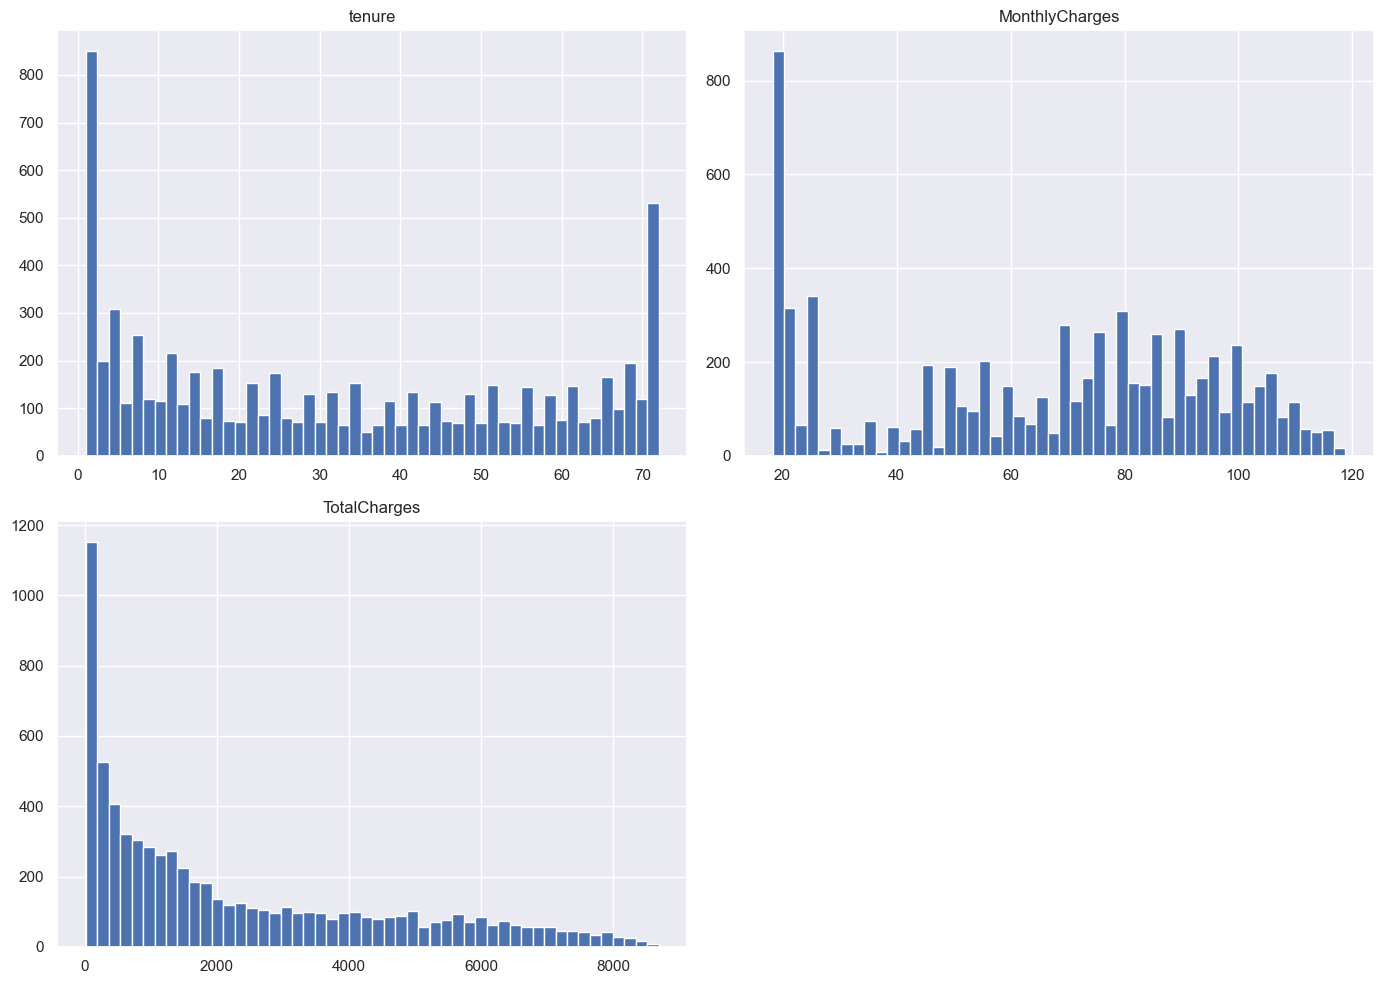

In [15]:
# Plot numerical variables
_ = telco_df.hist(bins=50, figsize=(14,10))

# This ensures the subplots do not overlap
plt.tight_layout()  
plt.show()

In [16]:
telco_df['TotalCharges'].skew()

np.float64(0.9616424997242504)

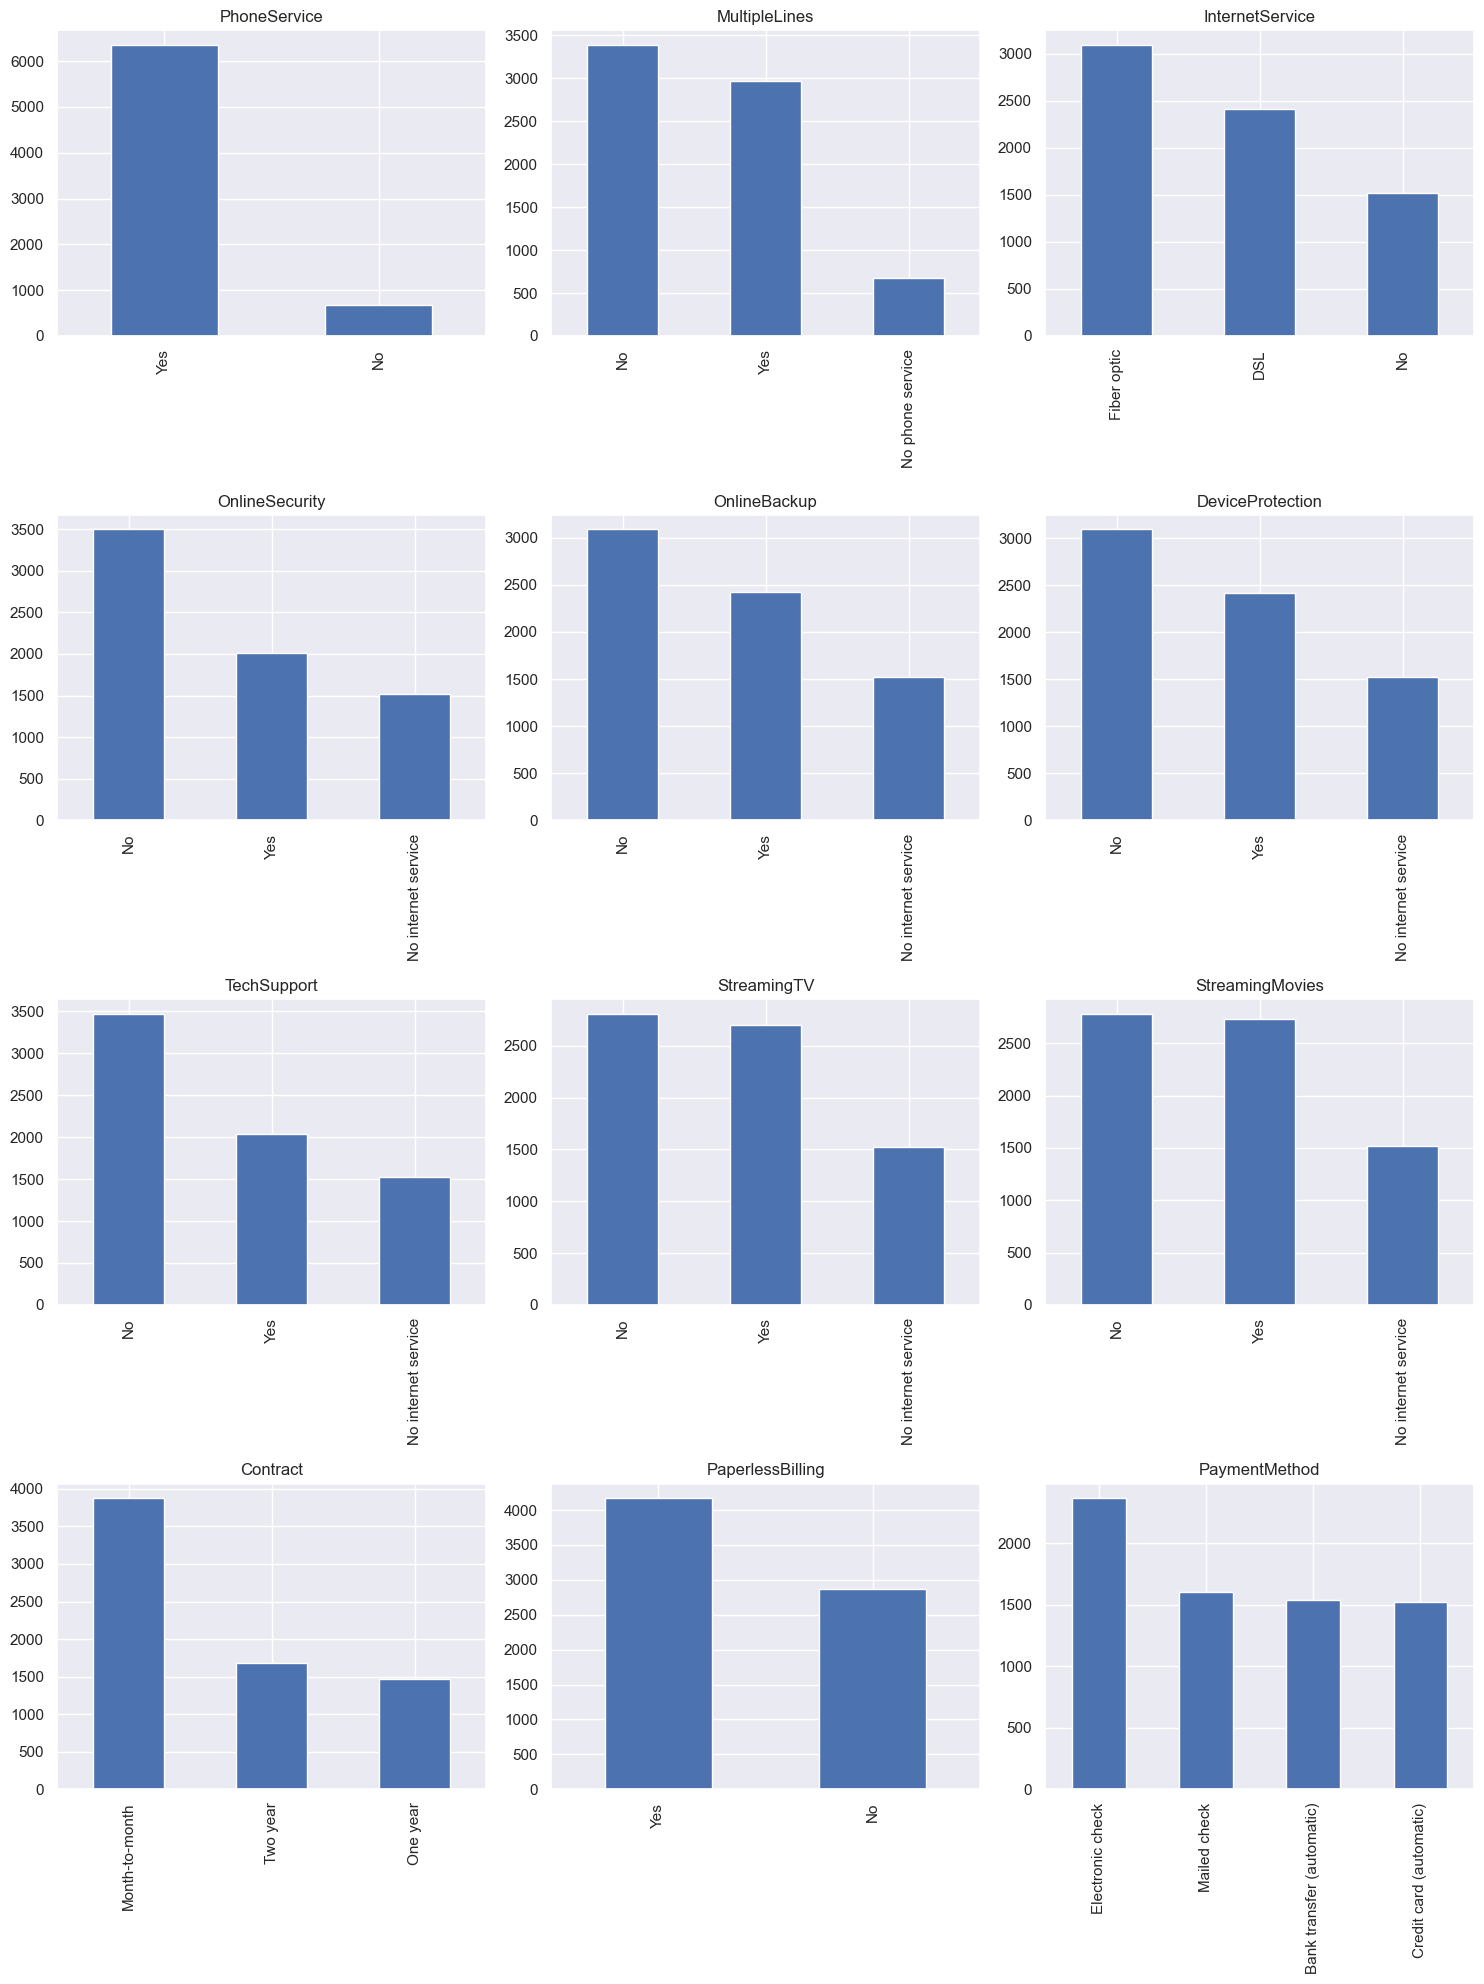

In [17]:
# Plot categorical columns
categ_cols = telco_df.select_dtypes(include=['object']).columns
num_plots = len(categ_cols)

# Determine number of rows needed for the grid
num_rows = math.ceil(num_plots / 3.0)

# Create subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Flatten the axes array if there's more than one row
axs = axs.flatten()

# Plot data
for i, column in enumerate(categ_cols):
    ax = axs[i] 
    telco_df[column].value_counts().plot(
        kind='bar', 
        ax=ax, 
        title=column, 
        xlabel=''
    )

plt.tight_layout()

In [18]:
# Get numerical and categorical columns
num_cols = list(set(telco_df.columns)-set(categ_cols))

# Scale numerical columns
telco_df['TotalCharges'] = np.sqrt(telco_df['TotalCharges'])

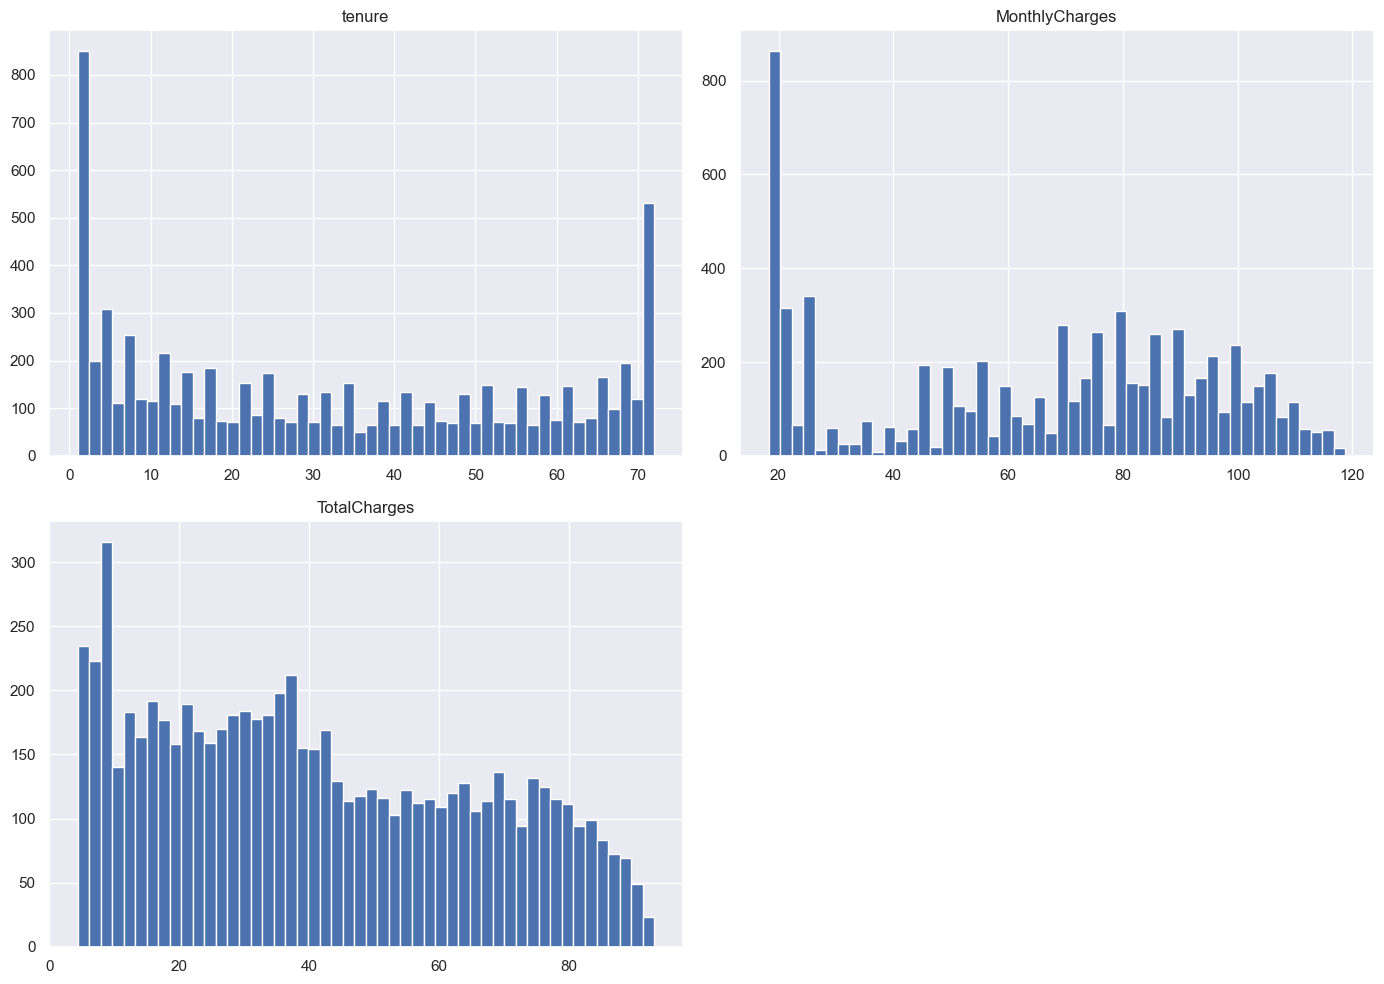

In [19]:
# Plot numerical variables
_ = telco_df.hist(bins=50, figsize=(14,10))

# This line ensures the subplots do not overlap
plt.tight_layout()  
plt.show()

In [20]:
# Scale numerical columns
standard_scaler = MinMaxScaler()
telco_df[num_cols] = standard_scaler.fit_transform(telco_df[num_cols])

# Encode categorical columns
ord_encoder = OrdinalEncoder(dtype=np.int32)
telco_df[categ_cols] = ord_encoder.fit_transform(telco_df[categ_cols])

In [21]:
# Get positions of categorical and numerical columns
df_cols = list(telco_df.columns)

numerical_idx = np.array(
    [idx for idx, element in enumerate(df_cols) if element in num_cols]
)

categ_idx = np.array(
    [idx for idx, element in enumerate(df_cols) if element in categ_cols]
)

categ_bool = [True if element in categ_cols else False for element in df_cols]

### UMAP

In [23]:
pairwise_gower = gower.gower_matrix(telco_df, cat_features=categ_bool)
pairwise_gower

array([[0.        , 0.6108101 , 0.2872294 , ..., 0.1527547 , 0.37474063,
        0.9026203 ],
       [0.6108101 , 0.        , 0.3235807 , ..., 0.4583871 , 0.45922038,
        0.55847687],
       [0.2872294 , 0.3235807 , 0.        , ..., 0.29736608, 0.28751126,
        0.68205756],
       ...,
       [0.1527547 , 0.4583871 , 0.29736608, ..., 0.        , 0.37045187,
        0.7501973 ],
       [0.37474063, 0.45922038, 0.28751126, ..., 0.37045187, 0.        ,
        0.661213  ],
       [0.9026203 , 0.55847687, 0.68205756, ..., 0.7501973 , 0.661213  ,
        0.        ]], shape=(7032, 7032), dtype=float32)

/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/umap/plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

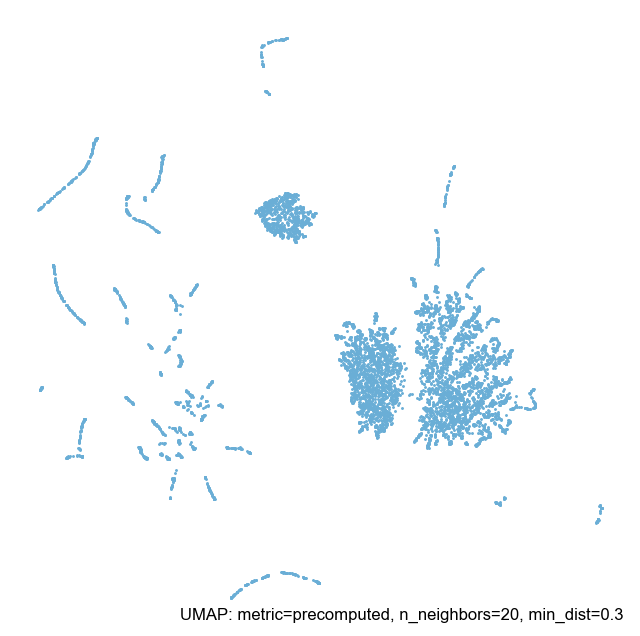

In [24]:
# Embed with umap
umap_model = umap.UMAP(
    n_neighbors=20, 
    n_components=2, 
    random_state=42, 
    metric='precomputed', 
    min_dist=0.3
)
umap_emb_data = umap_model.fit_transform(pairwise_gower)

uplot.points(umap_model)

<Axes: >

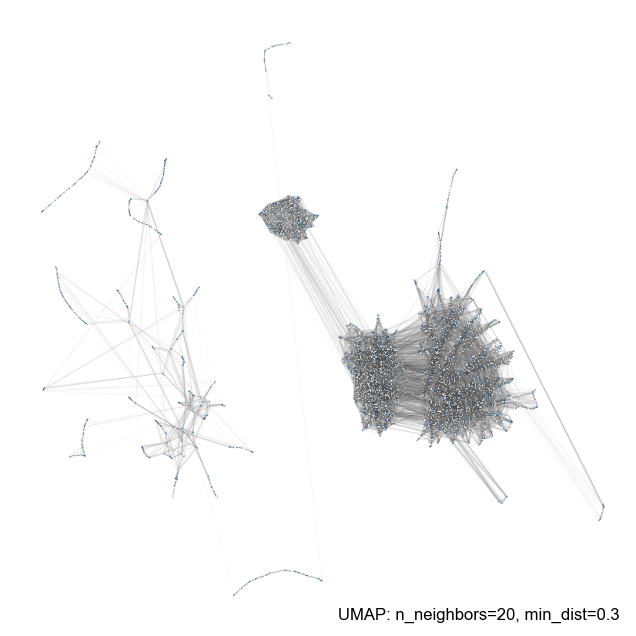

In [25]:
umap.plot.connectivity(umap_model, show_points=True)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

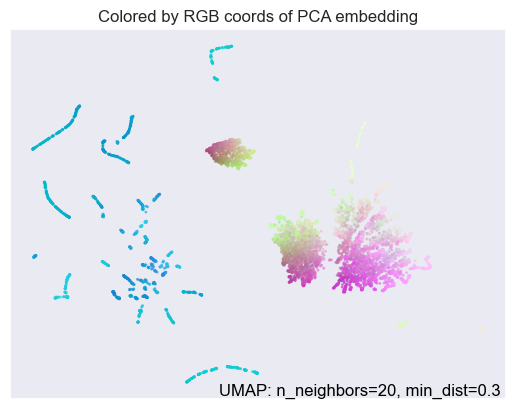

In [26]:
umap.plot.diagnostic(umap_model, diagnostic_type='pca')

/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/umap/plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

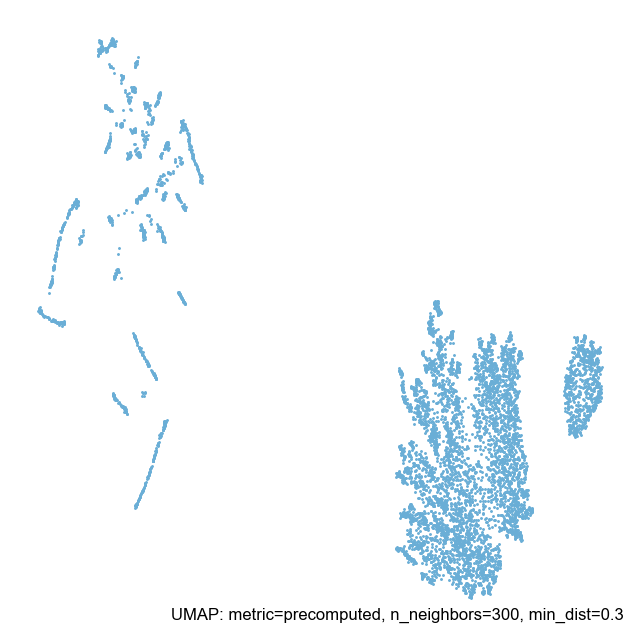

In [27]:
# Embed with umap
umap_model = umap.UMAP(
    n_neighbors=300, 
    n_components=2, 
    random_state=42, 
    metric='precomputed', 
    min_dist=0.3
)
umap_emb_data = umap_model.fit_transform(pairwise_gower)

uplot.points(umap_model)

<Axes: >

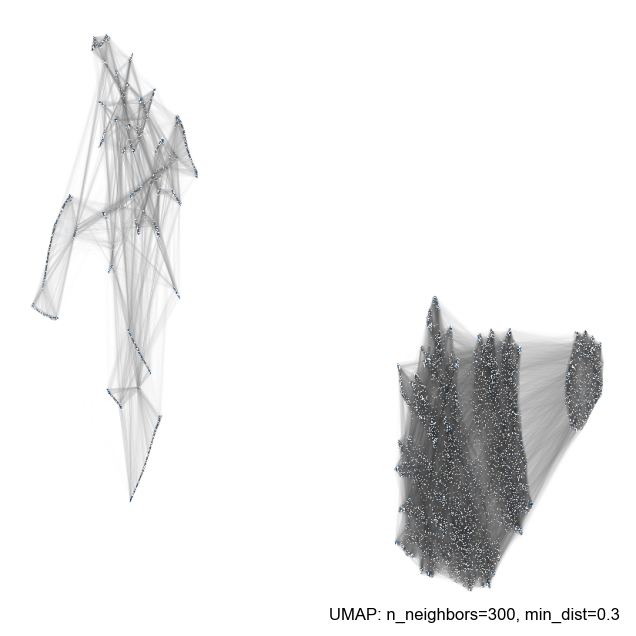

In [28]:
umap.plot.connectivity(umap_model, show_points=True)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

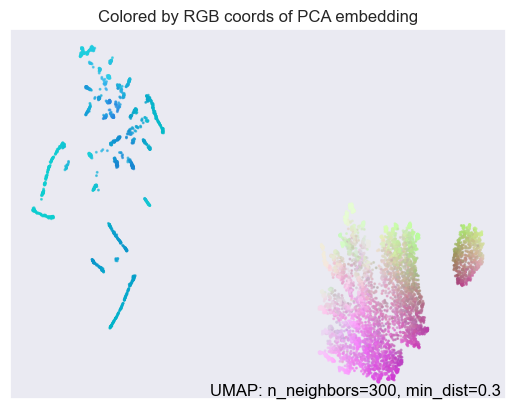

In [29]:
umap.plot.diagnostic(umap_model, diagnostic_type='pca')

### Mixed distance and k-prototypes

In [30]:
gamma = 1/2 * telco_df[num_cols].std().mean()
gamma

np.float64(0.15354419462541827)

In [31]:
def kproto_dist(x, y, num_idx, categ_idx, gamma):
    
    euclidean_part = np.sum(np.square(x[num_idx] - y[num_idx]))
    hamming_part = np.sum(x[categ_idx] == y[categ_idx])
    
    return euclidean_part + gamma*hamming_part

In [32]:
@njit
def kproto_dist_nmb(x, y, num_idx, categ_idx, gamma):
    
    euclidean_part = 0
    for i in num_idx:
        euclidean_part += (x[i] - y[i]) ** 2

    hamming_part = 0
    for i in categ_idx:
        if x[i] != y[i]:
            hamming_part += 1

    return euclidean_part + gamma * hamming_part

In [34]:
xx = telco_df.loc[0].to_numpy()
yy = telco_df.loc[1].to_numpy()

xx

array([0.        , 0.        , 1.        , 0.        , 0.        ,
       2.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 2.        , 0.11542289, 0.01269035])

In [35]:
%%timeit
kproto_dist_nmb(xx,yy,num_idx=numerical_idx, categ_idx=categ_idx, gamma=gamma)

530 ns ± 1.89 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [36]:
%%timeit
kproto_dist(xx,yy,num_idx=numerical_idx, categ_idx=categ_idx, gamma=gamma)

4.41 μs ± 218 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [37]:
kproto_pairwise = pairwise_distances(
    telco_df.to_numpy(), metric=kproto_dist_nmb, 
    num_idx=numerical_idx, categ_idx=categ_idx, 
    gamma=gamma
)

In [ ]:
def plot_silouethes_score(
    data, clusters, ax, colormap=None, 
    distance_measure='euclidean'
):
    
    y_lower = 10

    # Calculate average silhouette score
    silhouette_scr = silhouette_score(data, clusters, metric=distance_measure)
    
    # Calculate silhouette score for each data point
    sample_silhouette_values = silhouette_samples(data, clusters, metric=distance_measure)

    # Number of clusters
    num_clust = np.unique(clusters).shape[0]


    # Plot siluethe scores for points belonging to each cluster
    for clust_i in range(num_clust):
        
        # Get points bellogning to the current cluster
        ith_cluster_silhouette_values = sample_silhouette_values[
            clusters == clust_i
        ]
        
        # Sort points by silhouette value
        ith_cluster_silhouette_values.sort()
        
        # Get size of current cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        
        # Get upper value of y cooridnate for current cluster
        y_upper = y_lower + size_cluster_i
        
        # Fill values between y_lower and y_upper with silhouette score values
        # for data points

        if colormap:
            color = colormap[clust_i]
        else:
            color = cm.nipy_spectral(float(clust_i) / num_clust)

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(clust_i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        
    ax.axvline(x=silhouette_scr, color='r', linestyle='--')

    # Set title and labels for the silhouette subplot
    ax.set_yticklabels([])
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    return silhouette_scr

In [ ]:
# Perform clustering for multiple values of k
candidate_k = [2,3,4,5,6,7]
tab10 = list(matplotlib.colormaps['tab10'].colors)

cost_list = []
silhouette_list = []

fig, axs = plt.subplots(
    len(candidate_k), 2, 
    figsize=(12, len(candidate_k)*5)
)

cluster_label_dict = {}

for i, num_clust in enumerate(candidate_k):
    
    print('Performing clustering for k = {}'.format(num_clust))
    
    # Perform clustering for current number of clusters
    kproto = KPrototypes(n_clusters=num_clust, init='Cao', n_jobs=8)

    kproto.fit(telco_df.to_numpy(), categorical=list(categ_idx))
    
    sns.scatterplot(
        x=umap_emb_data[:,0], 
        y=umap_emb_data[:,1], 
        hue=kproto.labels_, 
        s=3, palette='tab10',
        ax=axs[i, 0]
    )
        
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    
    curr_silhouette = plot_silouethes_score(
        data=kproto_pairwise,
        clusters=kproto.labels_,
        ax=axs[i, 1],
        distance_measure='precomputed',
        colormap=tab10
    )
    
    cluster_label_dict[num_clust] = kproto.labels_
    cost_list.append(kproto.cost_)
    silhouette_list.append(curr_silhouette)

plt.show()

In [ ]:
plt.figure()
plt.plot(candidate_k, silhouette_list)
plt.title('Silhouette scores')
plt.xlabel('Number of clusters')
plt.ylabel('Score values')
plt.show()

In [ ]:
# Use knee locator to find best number of clusters
kneedle = KneeLocator(
    candidate_k, 
    cost_list, 
    S=1.0, 
    curve="convex", 
    direction="decreasing"
)
kneedle.plot_knee()

In [ ]:
uplot.points(umap_model, labels=original_df['Churn'].to_numpy())

In [ ]:
uplot.points(umap_model, labels=cluster_label_dict[5])

In [ ]:
# Add cluster info to df
original_df['cluster'] = cluster_label_dict[5]

## Cluster analysis

In [ ]:
original_df['cluster'].value_counts()

In [ ]:
# Plot other categorical data [not used during clustering]
for col in ['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']:
    
    if col != 'cluster':
        
        # Calculate proportions
        proportions = original_df.groupby(
            'cluster'
        )[col].value_counts(
            normalize=True
        ).unstack()
                
        # Create stacked bar plot
        ax = proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f'Cluster distribution for {col}')
        plt.ylabel('Proportion')

        # Add legend
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get category labels
        category_labels = proportions.columns.tolist()[::-1]

        # Add percentages and category labels on the stacks
        for i, patch in enumerate(ax.patches):
            width, height = patch.get_width(), patch.get_height()
            if height > 0:  # Skip patches with height 0
                x, y = patch.get_xy() 

                ax.text(x+width/2, 
                        y+height/2, 
                        '\n{:.0f} %'.format(height*100), 
                        horizontalalignment='center', 
                        verticalalignment='center')

        plt.show()

In [ ]:
# Categorical plots

for col in categ_cols:
    if col != 'cluster':
        
        # Calculate proportions
        proportions = original_df.groupby(
            'cluster'
        )[col].value_counts(
            normalize=True
        ).unstack()
                
        # Create stacked bar plot
        ax = proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f'Cluster distribution for {col}')
        plt.ylabel('Proportion')

        # Add legend
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get category labels
        category_labels = proportions.columns.tolist()[::-1]

        # Add percentages and category labels on the stacks
        for i, patch in enumerate(ax.patches):
            width, height = patch.get_width(), patch.get_height()
            if height > 0:  # Skip patches with height 0
                x, y = patch.get_xy() 

                ax.text(x+width/2, 
                        y+height/2, 
                        '\n{:.0f} %'.format(height*100), 
                        horizontalalignment='center', 
                        verticalalignment='center')

        plt.show()

In [ ]:
# Plot numerical 
for col in num_cols:
    
    plt.figure()
    sns.boxplot(original_df, x='cluster', y=col)
    plt.title(col)